# Kabam DS Take Home Assignment

### Wesley Chorney

In [1]:
#import required libraries
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import xgboost as xgb
import imblearn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix

#set seaborn as default
sns.set()

D:\Anaconda\lib\site-packages\dask\dataframe\utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
%matplotlib inline

## Reading in the Data

In [3]:
actions = pd.read_parquet('./ka_actions.parquet', engine='pyarrow')

In [4]:
users = pd.read_csv('./ka_users.csv')

In [5]:
con = sqlite3.connect('./ka_devices.db')
cur = con.cursor()

#get table info
#because we are going to investigate a lot of these columns,
#we won't use any fancy SQL
rows = [row for row in cur.execute('SELECT * FROM devices')]

#use the Row datatype for row_factory to get column names
con.row_factory = sqlite3.Row
cur = con.cursor()
columns = cur.execute('SELECT * FROM devices LIMIT 1').fetchone().keys()

#create the dataframe
devices = pd.DataFrame(rows, columns=columns)
devices.set_index('index', inplace=True)

In [6]:
devices.head(10)

,uid_s,platform_s,device_mapped_s,device_manufacturer_s,device_mem_i,device_gmem_i,device_mem_grouping_i,device_gmem_grouping_i,device_numcpu_i,device_height_i,device_gpu_s,device_os_s,device_model_s
index,,,,,,,,,,,,,
0,0,android,asus_x01ad,asus,3575.0,1024.0,3584.0,1024.0,8.0,720.0,adreno (tm) 506,android os 9 / api-28 (ww_phone-201905061022/1...,asus_x01ad
1,1,android,moto g (5),motorola,1867.0,512.0,1920.0,512.0,8.0,1080.0,adreno (tm) 505,android os 8.1.0 / api-27 (opps28.85-13-6/04442),moto g (5)
2,2,android,mi 6,xiaomi,3726.0,1024.0,3776.0,1024.0,8.0,1080.0,adreno (tm) 540,android os 8.0.0 / api-26 (opr1.170623.027/v10...,mi 6
3,3,android,oppo r7splus,oppo,3629.0,1024.0,3648.0,1024.0,8.0,1080.0,adreno (tm) 405,android os 5.1.1 / api-22 (lmy47v/eng.root.201...,oppo r7splus
4,4,android,cph1803,oppo,2816.0,1024.0,2816.0,1024.0,8.0,720.0,adreno (tm) 506,android os 8.1.0 / api-27 (opm1.171019.026/155...,cph1803
5,5,android,cph1729,oppo,2791.0,1024.0,2816.0,1024.0,8.0,720.0,mali-g71,android os 7.1.1 / api-25 (n6f26q/1553784554),cph1729
6,6,android,oneplus a6010,oneplus,5633.0,2048.0,5696.0,2048.0,8.0,1080.0,adreno (tm) 630,android os 9 / api-28 (pkq1.180716.001/1904032...,oneplus a6010
7,7,android,oppo a83,oppo,2791.0,1024.0,2816.0,1024.0,8.0,720.0,mali-g71,android os 7.1.1 / api-25 (n6f26q/1554776020),oppo a83
8,8,android,oppo a73,oppo,3780.0,1024.0,3840.0,1024.0,8.0,1080.0,mali-g71,android os 7.1.1 / api-25 (n6f26q/1555190393),oppo a73


In [7]:
users.head(10)

,uid_s,lang_s,geo_s,region_s,tz_i,local_time_join_hour,local_time_join_dow,total_spend
0,0,EN,MY,asia,28800,14,3,0
1,1,ES,MX,americas,-18000,14,1,0
2,2,ZH-CN,CN,asia,28800,2,3,0
3,3,ZH-CN,CN,asia,28800,8,6,0
4,4,EN,IN,asia,19800,19,6,0
5,5,EN,ID,asia,25200,11,6,0
6,6,EN,IN,asia,19800,23,2,0
7,7,ZH-CN,CN,asia,28800,22,2,0
8,8,ZH-CN,CN,asia,28800,16,6,0
9,9,EN,IN,asia,19800,6,6,0


In [8]:
actions.head(10)

,uid_s,logins,game_stats_tutorial_complete,game_stats_tutorial_complete_time,game_stats_xp,game_stats_xp1,game_stats_xp2,game_stats_xp3,redeemer_actions,scribe_actions
0,0,7.0,1.0,4.700000e+08,1693.0,592.0,0.0,429.0,446.0,364.0
1,1,2.0,1.0,6.120000e+08,197.0,197.0,0.0,0.0,60.0,125.0
2,2,2.0,1.0,3.900000e+08,313.0,313.0,0.0,0.0,89.0,129.0
3,3,3.0,1.0,6.610000e+08,1319.0,1319.0,0.0,0.0,275.0,200.0
4,4,4.0,1.0,3.147000e+09,148.0,148.0,0.0,0.0,58.0,138.0
5,5,4.0,1.0,5.470000e+08,879.0,312.0,0.0,0.0,209.0,186.0
6,6,2.0,NaN,NaN,NaN,NaN,NaN,NaN,17.0,48.0
7,7,2.0,1.0,5.820000e+08,313.0,313.0,0.0,0.0,87.0,128.0
8,8,2.0,NaN,NaN,80.0,80.0,0.0,0.0,36.0,99.0
9,9,3.0,1.0,2.131900e+10,193.0,80.0,0.0,0.0,60.0,133.0


In [9]:
#replace nans in the tutorial completion column with zero
actions['game_stats_tutorial_complete'] = actions['game_stats_tutorial_complete'].fillna(0)

In [10]:
users.shape, actions.shape

((2845931, 8), (2845931, 10))

In [11]:
#A small amount of conversions!
users[users['total_spend'] != 0]

,uid_s,lang_s,geo_s,region_s,tz_i,local_time_join_hour,local_time_join_dow,total_spend
13,13,ZH-CN,CN,asia,28800,11,6,70
160,160,EN,US,americas,-18000,15,5,140
181,181,JA,JP,asia,32400,5,6,160
214,214,EN,US,americas,-14400,16,5,70
551,551,EN,US,americas,-18000,15,5,40
...,...,...,...,...,...,...,...,...
2845298,2845298,ZH-CN,CN,asia,28800,15,5,40
2845309,2845309,ZH-TW,CN,asia,28800,15,5,125
2845589,2845589,ZH-CN,CN,asia,28800,15,5,285
2845632,2845632,EN,VN,asia,25200,14,5,35


In [12]:
#create label column for classification
users['converted'] = (users['total_spend'] > 0).apply(int)

In [13]:
#merge frames
#though the data looks perfectly aligned it is safer to merge
df1 = pd.merge(actions, devices, on='uid_s')
df = pd.merge(users, df1, on='uid_s')

completed = df[df['game_stats_tutorial_complete'] != 0].copy()

In [14]:
#data is well-aligned
print(df.shape)
print(completed.shape)

(2845931, 30)
(1751748, 30)


## Preprocessing/EDA Phase

We begin with a short EDA of the data. We have a wealth of data, but we will convert our data to numeric values for ease-of-use when modelling. Some columns we will drop altogether, since they are irrelevant or should be highly correlated to other columns (such as `lang_s`, `tz_i`, `game_stats_tutorial_complete`), while others we will first investigate before dropping or altering the values. 

For many of these columns, we will look at whether the distributions differ significantly between converted versus non-converted users. If there appears to be little difference, we will drop the columns. Note that this approach is technically naive, we are not considering joint distributions. However, given limited computing power and a relatively small amount of time, it is a reasonable procedure for trimming down features.

We first begin by looking into the NaN values in our data.

In [15]:
completed.isna().sum()

uid_s                                 0
lang_s                                0
geo_s                                66
region_s                              0
tz_i                                  0
local_time_join_hour                  0
local_time_join_dow                   0
total_spend                           0
converted                             0
logins                               12
game_stats_tutorial_complete          0
game_stats_tutorial_complete_time     0
game_stats_xp                        63
game_stats_xp1                       63
game_stats_xp2                       63
game_stats_xp3                       63
redeemer_actions                      0
scribe_actions                        0
platform_s                            0
device_mapped_s                       4
device_manufacturer_s                 2
device_mem_i                          1
device_gmem_i                         1
device_mem_grouping_i                 1
device_gmem_grouping_i                1


With such a small amount of NaNs compared to our data, it is safe to drop them.

In [16]:
completed.dropna(inplace=True)

Percent converted users: 1.14


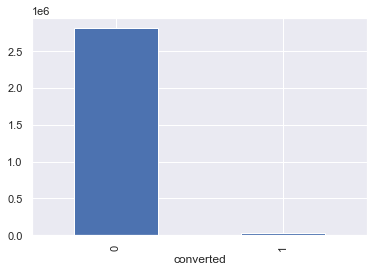

In [17]:
#see converted users overall and print their percent
users.groupby('converted').size().plot(kind='bar')
print(f"Percent converted users: {round(100*users['converted'].sum()/users.shape[0],2)}")

Percent converted users: 1.75


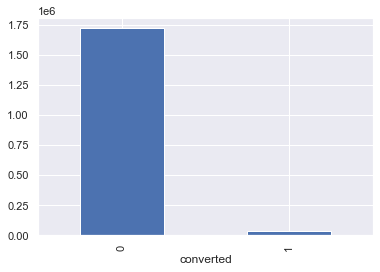

In [18]:
#see converted users out of those who have completed tutorial and print their percent
completed.groupby('converted').size().plot(kind='bar')
print(f"Percent converted users: {round(100*completed['converted'].sum()/completed.shape[0],2)}")

<AxesSubplot:xlabel='game_stats_tutorial_complete'>

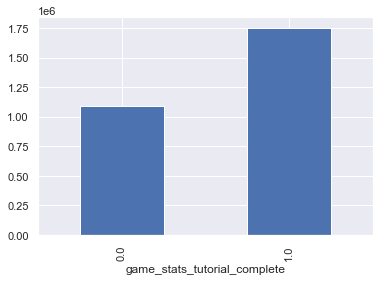

In [19]:
actions.groupby('game_stats_tutorial_complete').size().plot(kind='bar')

In [20]:
print(f"Fraction of users who completed the tutorial: {completed.shape[0]/df.shape[0]}")

Fraction of users who completed the tutorial: 0.6154766225885308


In [21]:
completed.drop(columns=['lang_s', 'tz_i', 'game_stats_tutorial_complete'], inplace=True)

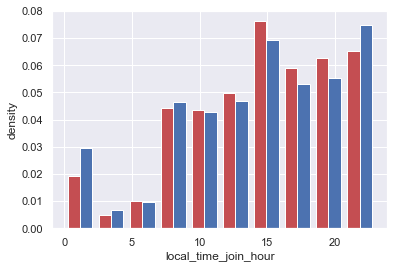

In [22]:
def make_hist(df, plot_col, col, filters, bins=None, **kwargs):
    plt.clf()
    x = df[df[col] == filters][plot_col]
    y = df[df[col] != filters][plot_col]
    plt.hist([x, y], color=['r', 'b'], bins=bins, density=True)
    plt.title(kwargs.get('title', ''))
    plt.xlabel(kwargs.get('xlabel', ''))
    plt.ylabel(kwargs.get('ylabel', ''))
    plt.show()
    return

#drop this column
make_hist(completed, 'local_time_join_hour', 'converted', 0, xlabel='local_time_join_hour', ylabel='density')

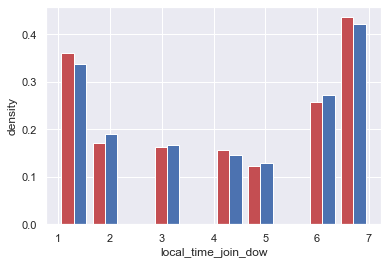

In [23]:
#drop this column
make_hist(completed, 'local_time_join_dow', 'converted', 0, xlabel='local_time_join_dow', ylabel='density')

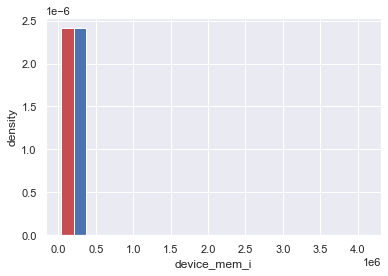

In [24]:
#drop this column and related
make_hist(completed, 'device_mem_i', 'converted', 0, xlabel='device_mem_i', ylabel='density')

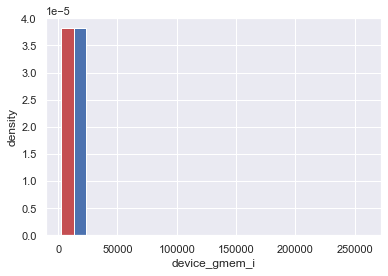

In [25]:
#drop this column and related
make_hist(completed, 'device_gmem_i', 'converted', 0, xlabel='device_gmem_i', ylabel='density')

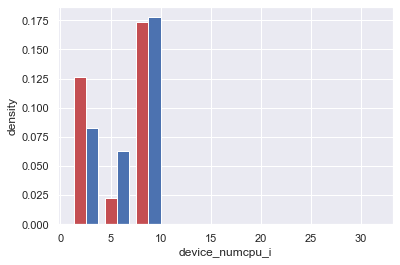

In [26]:
#keep this column
make_hist(completed, 'device_numcpu_i', 'converted', 0, xlabel='device_numcpu_i', ylabel='density')

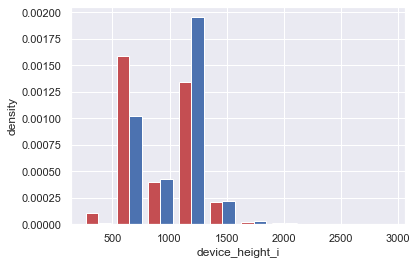

In [27]:
#keep this column
make_hist(completed, 'device_height_i', 'converted', 0, xlabel='device_height_i', ylabel='density')

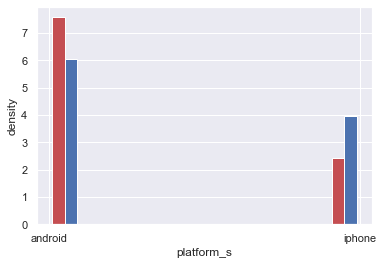

In [28]:
#keep this column
make_hist(completed, 'platform_s', 'converted', 0, xlabel='platform_s', ylabel='density')

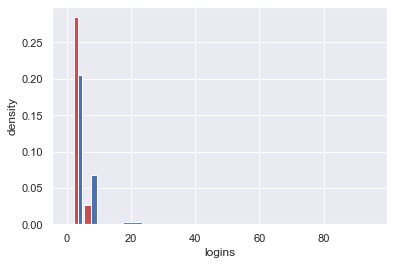

In [29]:
#keep this column
make_hist(completed, 'logins', 'converted', 0, xlabel='logins', ylabel='density', bins=[0, 2, 5, 10, 25, 50, 100])

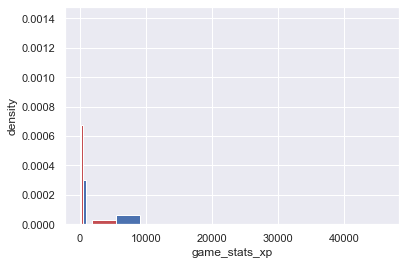

In [30]:
#keep this column
make_hist(completed, 'game_stats_xp', 'converted', 0, xlabel='game_stats_xp',
          ylabel='density', bins=[0, 100, 1000, 10000, 50000])

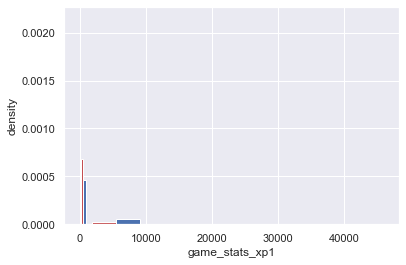

In [31]:
#keep this column
make_hist(completed, 'game_stats_xp1', 'converted', 0, xlabel='game_stats_xp1',
          ylabel='density', bins=[0, 100, 1000, 10000, 50000])

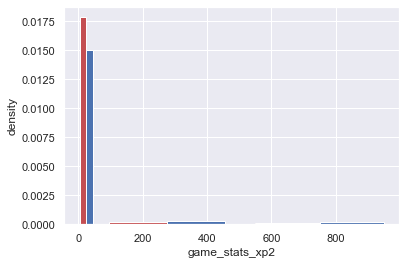

In [32]:
#keep this column
make_hist(completed, 'game_stats_xp2', 'converted', 0, xlabel='game_stats_xp2',
          ylabel='density', bins=[0, 50, 500, 1000])

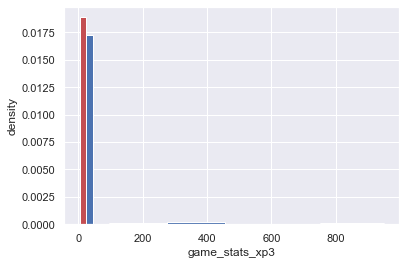

In [33]:
#keep this column
make_hist(completed, 'game_stats_xp3', 'converted', 0, xlabel='game_stats_xp3',
          ylabel='density', bins=[0, 50, 500, 1000])

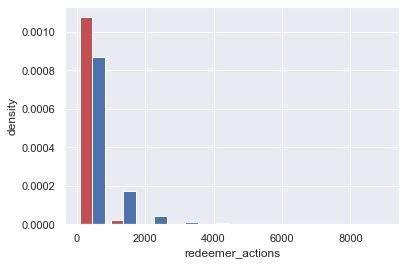

In [34]:
#keep this column
make_hist(completed, 'redeemer_actions', 'converted', 0, xlabel='redeemer_actions', ylabel='density')

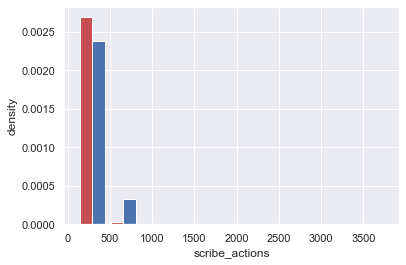

In [35]:
#keep this column
make_hist(completed, 'scribe_actions', 'converted', 0, xlabel='scribe_actions', ylabel='density')

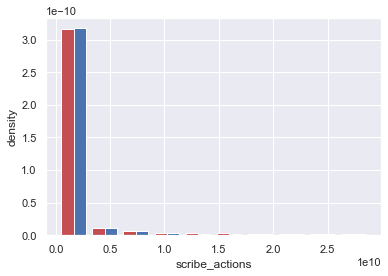

In [36]:
#drop this column
make_hist(completed, 'game_stats_tutorial_complete_time', 'converted', 0, xlabel='scribe_actions', ylabel='density')

In [37]:
drop_cols = ['local_time_join_hour', 'local_time_join_dow', 'device_mapped_s', 'device_manufacturer_s',\
             'device_mem_i', 'device_gmem_i', 'device_mem_grouping_i', 'device_gmem_grouping_i',\
            'device_gpu_s', 'device_os_s', 'device_model_s', 'game_stats_tutorial_complete_time']

completed.drop(columns=drop_cols, inplace=True)

We now convert the columns we kept to numeric values, normally by one-hot encoding. To ensure the data is not too wide, we reduce the number of categories in each column.

In [38]:
completed.groupby('geo_s').size().sort_values(ascending=False).head(10)

geo_s
CN    652368
US    196398
BR    108151
IN     86058
MX     84638
RU     48570
GB     40171
TR     39810
JP     32439
IT     32254
dtype: int64

<AxesSubplot:xlabel='region_s'>

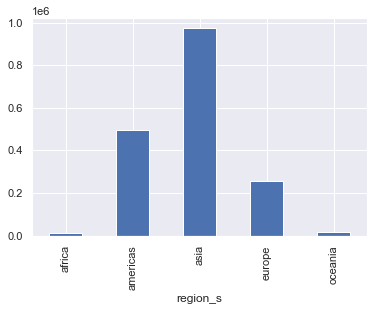

In [39]:
completed.groupby('region_s').size().plot(kind='bar')

The difference between `region_s` and `geo_s` seems significant; however, we will collapse all but the top three entries in `geo_s` to identical values.

In [40]:
def geo_map(val):
    if val in ['CN', 'US', 'BR']:
        return val
    else:
        return 'Other'
    
completed['geo'] = completed['geo_s'].apply(geo_map)
completed.drop(columns=['geo_s'], inplace=True)

In [41]:
completed.head(10)

,uid_s,region_s,total_spend,converted,logins,game_stats_xp,game_stats_xp1,game_stats_xp2,game_stats_xp3,redeemer_actions,scribe_actions,platform_s,device_numcpu_i,device_height_i,geo
0,0,asia,0,0,7.0,1693.0,592.0,0.0,429.0,446.0,364.0,android,8.0,720.0,Other
1,1,americas,0,0,2.0,197.0,197.0,0.0,0.0,60.0,125.0,android,8.0,1080.0,Other
2,2,asia,0,0,2.0,313.0,313.0,0.0,0.0,89.0,129.0,android,8.0,1080.0,CN
3,3,asia,0,0,3.0,1319.0,1319.0,0.0,0.0,275.0,200.0,android,8.0,1080.0,CN
4,4,asia,0,0,4.0,148.0,148.0,0.0,0.0,58.0,138.0,android,8.0,720.0,Other
5,5,asia,0,0,4.0,879.0,312.0,0.0,0.0,209.0,186.0,android,8.0,720.0,Other
7,7,asia,0,0,2.0,313.0,313.0,0.0,0.0,87.0,128.0,android,8.0,720.0,CN
9,9,asia,0,0,3.0,193.0,80.0,0.0,0.0,60.0,133.0,android,8.0,720.0,Other
11,11,asia,0,0,2.0,314.0,314.0,0.0,0.0,99.0,128.0,android,8.0,720.0,CN
12,12,asia,0,0,2.0,80.0,80.0,0.0,0.0,52.0,126.0,android,8.0,1080.0,CN


Now, we just need to one-hot encode the non-numeric variables. 

In [42]:
platform = pd.get_dummies(completed['platform_s'])
region = pd.get_dummies(completed['region_s'])
geo = pd.get_dummies(completed['geo'])

completed.drop(columns=['platform_s', 'region_s', 'geo'], inplace=True)
completed = pd.concat([completed, platform, region, geo], axis=1)
completed.head(15)

,uid_s,total_spend,converted,logins,game_stats_xp,game_stats_xp1,game_stats_xp2,game_stats_xp3,redeemer_actions,scribe_actions,...,iphone,africa,americas,asia,europe,oceania,BR,CN,Other,US
0,0,0,0,7.0,1693.0,592.0,0.0,429.0,446.0,364.0,...,0,0,0,1,0,0,0,0,1,0
1,1,0,0,2.0,197.0,197.0,0.0,0.0,60.0,125.0,...,0,0,1,0,0,0,0,0,1,0
2,2,0,0,2.0,313.0,313.0,0.0,0.0,89.0,129.0,...,0,0,0,1,0,0,0,1,0,0
3,3,0,0,3.0,1319.0,1319.0,0.0,0.0,275.0,200.0,...,0,0,0,1,0,0,0,1,0,0
4,4,0,0,4.0,148.0,148.0,0.0,0.0,58.0,138.0,...,0,0,0,1,0,0,0,0,1,0
5,5,0,0,4.0,879.0,312.0,0.0,0.0,209.0,186.0,...,0,0,0,1,0,0,0,0,1,0
7,7,0,0,2.0,313.0,313.0,0.0,0.0,87.0,128.0,...,0,0,0,1,0,0,0,1,0,0
9,9,0,0,3.0,193.0,80.0,0.0,0.0,60.0,133.0,...,0,0,0,1,0,0,0,0,1,0
11,11,0,0,2.0,314.0,314.0,0.0,0.0,99.0,128.0,...,0,0,0,1,0,0,0,1,0,0
12,12,0,0,2.0,80.0,80.0,0.0,0.0,52.0,126.0,...,0,0,0,1,0,0,0,1,0,0


## Modelling Phase

With the exploratory data analysis complete above, we begin modelling. Here, our goal is to determine those users who are likely to spend money in the game after completing the tutorial. Since the question is specific to those players who spend money in the game after finishing the tutorial, we use the dataframe with only those players who have completed the tutorial.

Based on the figure of converted versus non-converted users, we have an extremely imbalanced dataset. This is typical of conversion problems, especially in the mobile game domain. We begin by splitting our datasets into train, validation, and test sets, then we discuss how to proceed with the training set. Since we have a decent amount of data, we use 35\% as testing and validation.

In [43]:
#drop total spend column and user id
completed.drop(columns=['total_spend', 'uid_s'], inplace=True)

df_train, df_mid = train_test_split(completed, test_size=0.35, random_state=777)

In [44]:
df_val, df_test = train_test_split(df_mid, test_size=0.5, random_state=777)

In [45]:
def column_separator(df, col='converted'):
    y = df[col]
    X = df.drop(columns=[col])
    return X, y

X_val, y_val = column_separator(df_val)
X_test, y_test = column_separator(df_test)

Next, we normalize the data. Because we will test a neural network, this step will ensure better results. 

In [46]:
scaler = MinMaxScaler()
df_cols = df_train.columns

#learn the scaler on training data
df_train = scaler.fit_transform(df_train)

#change it back to dataframe for slicing, this is a bit wonky,
#but need to downsample for SMOTE and this is preferring clarity
df_train = pd.DataFrame(df_train, columns=df_cols)

We still have the issue of an imbalanced dataset. Downsampling or optimizing a metric like F1 score is an option; however, we will use a combination of downsampling and oversampling, because the minority class (converted users) is so small (and this is best practice with the oversampling technique we use). To do so, we will use SMOTE, since it is available in tested libraries. Given more time, LoRAS seems to perform better than SMOTE, but since this is a technical assessment, I won't be implementing LoRAS. 

In [47]:
smote = imblearn.over_sampling.SMOTE()

#first downsample the train set
df_downsampled = df_train[df_train['converted'] == 0].sample(n=round(1.5*df_train['converted'].sum()))
#can use this for more class samples
df_other = df_train[(~df_train.index.isin(df_downsampled.index)) & (df_train['converted'] == 0)]
df_train_downsampled = pd.concat([df_downsampled, df_train[df_train['converted'] == 1]], axis=0)

#now split into X, y and upsample minority class
X_train, y_train = column_separator(df_train_downsampled)
X_train, y_train = smote.fit_resample(X_train, y_train)

#add some from majority class back
#other_samples = df_other.sample(n=round(0.33*X_train.shape[0]))
#X_other, y_other = column_separator(other_samples)
#X_train, y_train = pd.concat([X_train, X_other], axis=0), pd.concat([y_train, y_other], axis=0)

#ensure upsampling worked, should print out 0.376 if adding some from majority back
#otherwise should print out 0.5
print(y_train.sum()/y_train.shape[0])

0.5


Next, we test two models on the data. First, an XGBoost model; and second, a basic neural network.

In [48]:
clf1 = xgb.XGBClassifier()

clf1.fit(X_train, y_train)

pred_val = clf1.predict(X_val)

In [49]:
print(classification_report(y_val, pred_val))
print(confusion_matrix(y_val, pred_val))

              precision    recall  f1-score   support

           0       0.98      0.01      0.01    301191
           1       0.02      0.99      0.03      5340

    accuracy                           0.02    306531
   macro avg       0.50      0.50      0.02    306531
weighted avg       0.97      0.02      0.01    306531

[[  1883 299308]
 [    33   5307]]


It is very likely these results could be improved by hyperparameter tuning, but since it is a somewhat expensive operation, we instead try creating a neural network.

In [50]:
def const(x):
    return x

class BasicBlock(nn.Module):
    def __init__(self, in_features, out_features, p=0.3, batchnorm=True, activation=nn.LeakyReLU):
        super(BasicBlock, self).__init__()
        self.layer1 = nn.Linear(in_features, out_features)
        self.layer2 = nn.BatchNorm1d(out_features) if batchnorm else const
        self.layer3 = activation()
        self.layer4 = nn.Dropout(p=p)

    def forward(self, inputs):
        return self.layer4(self.layer3(self.layer2(self.layer1(inputs))))

class Classifier(nn.Module):
    def __init__(self, input_shape, n_layers, outs_ins):
        super(Classifier, self).__init__()
        if len(outs_ins) != n_layers - 1:
            raise ValueError(f"Layer output/input features must be one less than n_layers.")
        self.module_list = nn.ModuleList()
        for layer in range(n_layers):
            if layer == 0:
                #first layer
                self.module_list.append(BasicBlock(input_shape, outs_ins[0]))
            elif layer != n_layers - 1:
                self.module_list.append(BasicBlock(outs_ins[layer - 1], outs_ins[layer]))
            else:
                #final layer
                self.module_list.append(BasicBlock(outs_ins[layer-1], 1, p=0, activation=nn.Sigmoid))

    def forward(self, inputs):
        for layer in self.module_list:
            inputs = layer(inputs)
        return inputs

In [51]:
#Create datasets for our data
train_data = torch.utils.data.TensorDataset(torch.FloatTensor(X_train.to_numpy()), torch.unsqueeze(torch.FloatTensor(y_train.to_numpy()), -1))
val_data = torch.utils.data.TensorDataset(torch.FloatTensor(X_val.to_numpy()), torch.unsqueeze(torch.FloatTensor(y_val.to_numpy()), -1))
test_data = torch.utils.data.TensorDataset(torch.FloatTensor(X_test.to_numpy()), torch.unsqueeze(torch.FloatTensor(y_test.to_numpy()), -1))

In [52]:
#Create dataloaders
#tunable parameter batch size
batch_size = 64

train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

[1,   250] loss: 0.6498166
[1,   500] loss: 0.6021667
[1,   750] loss: 0.5861290
[2,   250] loss: 0.5672829
[2,   500] loss: 0.5628021
[2,   750] loss: 0.5573879
[3,   250] loss: 0.5509206
[3,   500] loss: 0.5494019
[3,   750] loss: 0.5421108
[4,   250] loss: 0.5389126
[4,   500] loss: 0.5321643
[4,   750] loss: 0.5378090
[5,   250] loss: 0.5322535
[5,   500] loss: 0.5266893
[5,   750] loss: 0.5278003
[6,   250] loss: 0.5259079
[6,   500] loss: 0.5279832
[6,   750] loss: 0.5248702
[7,   250] loss: 0.5181286
[7,   500] loss: 0.5235438
[7,   750] loss: 0.5225469
[8,   250] loss: 0.5276947
[8,   500] loss: 0.5151928
[8,   750] loss: 0.5169601
[9,   250] loss: 0.5212060
[9,   500] loss: 0.5112346
[9,   750] loss: 0.5148877
[10,   250] loss: 0.5148120
[10,   500] loss: 0.5085534
[10,   750] loss: 0.5152024
[11,   250] loss: 0.5137129
[11,   500] loss: 0.5067357
[11,   750] loss: 0.5136320
[12,   250] loss: 0.5068404
[12,   500] loss: 0.5111359
[12,   750] loss: 0.5185324
[13,   250] loss: 0

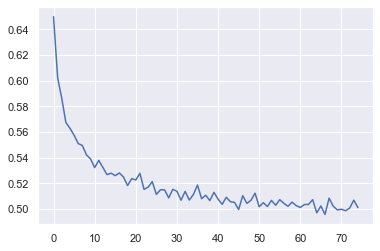

In [53]:
losses = []

#more hyperparameters
criterion = nn.BCELoss()
epochs = 25
lr = 1e-4
weight_decay=1e-4

clf = Classifier(20, 5, [128, 256, 512, 512])
optimizer = torch.optim.Adam(clf.parameters(), lr=lr, weight_decay=weight_decay)

###################
## TRAINING LOOP ##
###################
clf.train()
for epoch in range(epochs):
    running_loss = 0.
    for idx, data in enumerate(train_dataloader, 0):
        inputs, labels = data
        clf.zero_grad()
        outputs = clf(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if idx % 250 == 249:
            print('[%d, %5d] loss: %.7f' %
                    (epoch + 1, idx + 1, running_loss/249))
            losses.append(running_loss/249)
            running_loss = 0.0

########################
## VALIDATION RESULTS ##
########################
correct = 0
total = 0
clf.eval()
with torch.no_grad():
    for data in val_dataloader:
        inputs, labels = data
        labels = torch.squeeze(labels)
        outputs = clf(inputs)
        predicted = torch.squeeze((outputs > .5).float())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Model accuracy: %.4f'  %(100*correct/total))
plt.plot(losses)

Given the much better performance of the neural network on the validation set than XGBoost model, we use it as the proposed solution to the problem. Finally, we give the results of the model on the test set.

In [54]:
out = clf(torch.Tensor(X_test.to_numpy()))

In [55]:
out = torch.squeeze(out).detach().numpy()

In [56]:
print(classification_report(y_test, out > 0.5))
print(confusion_matrix(y_test, out > 0.5))

              precision    recall  f1-score   support

           0       0.97      0.41      0.58    301163
           1       0.01      0.24      0.01      5368

    accuracy                           0.41    306531
   macro avg       0.49      0.33      0.30    306531
weighted avg       0.95      0.41      0.57    306531

[[123865 177298]
 [  4069   1299]]


Notice that in terms of results, this model performs better than XGBoost in nearly every metric except for its precision with respect to the positive class. Is this a meaningful improvement over the XGBoost model? A more full cost-benefit analysis would be required to answer this question. Implementing both models and in a hypothesis test would give a statistically sound answer, or we could determine the heuristic best approach if we had estimates for cost of missing out on the relative value of true positives, true negatives, false positives, and false negatives.

## Limitations and Future Work

Note that there are some limitations to the dataset. First, we are asked to determine those users who are likely to spend money in the game after completing the tutorial. However, the user data is aggregated, so the only information on spending is an aggregate field and we are not guaranteed that users have purchased an item before finishing the tutorial, and then subsequently finished the tutorial (so that they were only likely to spend money in game before finishing the tutorial). While, if items can be purchased before the tutorial, this is likely an extremely small group, it is worth investigating.

Another limitation is the aggregate nature of the data. While we achieve okay predictive power for a greatly imbalanced problem, seeing sequential information could lead to more accurate predictions. Future work could involve the use of more complex models to capture more intricate patterns in the data, or could incorporate cost analysis for true positives, true negatives, false positives, and false negatives, to optimize a model based on the estimated cost of each outcome. 

Regardless the model used, hyperparameter tuning should be done to ensure the chosen architecture is optimal. Given competing models that seem approximately equal, a strategy like multi-armed bandits could be used as well.